<a href="https://colab.research.google.com/github/harshitadd/DP-NLP/blob/main/BERTNewsClassificationDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash 
pip install torchcsprng==0.1.3+cu101 -f https://download.pytorch.org/whl/torch_stable.html
git clone https://github.com/pytorch/opacus.git  
cd opacus
pip install -e .

In [ ]:
! pip install transformers --quiet

In [ ]:
! pip install codecarbon --quiet

In [ ]:
exit()

In [1]:
import zipfile
import urllib.request
import os
import torch
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import pandas as pd
import transformers
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from opacus.utils.uniform_sampler import UniformWithReplacementSampler
from opacus import PrivacyEngine
from torch.utils.data import TensorDataset
from transformers.data.processors.utils import InputExample
from transformers.data.processors.glue import glue_convert_examples_to_features
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification
from codecarbon import OfflineEmissionsTracker

In [2]:
tracker = OfflineEmissionsTracker(country_iso_code="CAN")

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.


In [3]:
DATA_DIR = "/content/"

In [4]:
# def download_and_extract(data_dir):
#   print("Extracting Train zip...")
#   filename = "train.csv.zip"
#   with zipfile.ZipFile(filename) as zip_ref:
#       zip_ref.extractall(data_dir)
#   os.remove(filename)
#   print("Completed!")

#   print("Extracting Test zip...")
#   filename = "test.csv.zip"
#   with zipfile.ZipFile(filename) as zip_ref:
#       zip_ref.extractall(data_dir)
#   os.remove(filename)
#   print("Completed!")

# download_and_extract(DATA_DIR)

In [5]:
train_path =  '/content/train.csv'
dev_path = '/content/test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(dev_path)

In [6]:
df_train = df_train.drop('Title', axis = 1)[:15000]
df_test = df_test.drop('Title', axis = 1)[:3000]
df_train = df_train.replace({'Class Index': {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}})
df_test = df_test.replace({'Class Index': {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}})

In [ ]:
model_name = "bert-base-cased"
config = BertConfig.from_pretrained(
    model_name,
    num_labels=4,
)
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-cased",
    do_lower_case=False,
)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    config=config,
)

In [8]:
# trainable_layers = [model.bert.encoder.layer[-1], model.bert.pooler, model.classifier]
trainable_layers = [model.classifier]
total_params = 0
trainable_params = 0

for p in model.parameters():
        p.requires_grad = False
        total_params += p.numel()

for layer in trainable_layers:
    for p in layer.parameters():
        p.requires_grad = True
        trainable_params += p.numel()

print(f"Total parameters count: {total_params}") # ~108M
print(f"Trainable parameters count: {trainable_params}") # ~7M

Total parameters count: 108313348
Trainable parameters count: 3076


In [9]:
LABEL_LIST = ['World','Sports','Business','Sci/Tech'] 
MAX_SEQ_LENGHT = 128


def _create_examples(df, set_type):
    """ Convert raw dataframe to a list of InputExample. Filter malformed examples
    """
    examples = []
    for index, row in df.iterrows():
        guid = f"{index}-{set_type}"
        examples.append(
            InputExample(guid=guid, text_a=row['Description'], label=row['Class Index']))
    return examples

def _df_to_features(df, set_type):
    examples = _create_examples(df, set_type)
    
    #backward compatibility with older transformers versions
    legacy_kwards = {}
    from packaging import version
    if version.parse(transformers.__version__) < version.parse("2.9.0"):
        legacy_kwards = {
            "pad_on_left": False,
            "pad_token": tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
            "pad_token_segment_id": 0,
        }
    
    return glue_convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        label_list=LABEL_LIST,
        max_length=MAX_SEQ_LENGHT,
        output_mode="classification",
        **legacy_kwards,
    )

def _features_to_dataset(features):
    """ Convert features from `_df_to_features` into a single dataset
    """
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor(
        [f.attention_mask for f in features], dtype=torch.long
    )
    all_token_type_ids = torch.tensor(
        [f.token_type_ids for f in features], dtype=torch.long
    )
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    dataset = TensorDataset(
        all_input_ids, all_attention_mask, all_token_type_ids, all_labels
    )

    return dataset

In [10]:
train_features = _df_to_features(df_train, "train")

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [11]:
test_features = _df_to_features(df_test, "test")

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [12]:
train_dataset = _features_to_dataset(train_features)
test_dataset = _features_to_dataset(test_features)

In [13]:
BATCH_SIZE = 8
VIRTUAL_BATCH_SIZE = 32
assert VIRTUAL_BATCH_SIZE % BATCH_SIZE == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / BATCH_SIZE)

In [14]:

SAMPLE_RATE = BATCH_SIZE / len(train_dataset)

train_sampler=UniformWithReplacementSampler(
    num_samples=len(train_dataset),
    sample_rate=SAMPLE_RATE,
)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [15]:
# Move the model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to train mode (HuggingFace models load in eval mode)
model = model.train()

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=1e-8)

In [16]:
EPOCHS = 26
LOGGING_INTERVAL = 1000 # once every how many steps we run evaluation cycle and report metrics
# EPSILON = float('inf')
# ( Will check with Eps = 0.5, 2, 5, 15 )

DELTA = 1 / len(train_dataloader) # Parameter for privacy accounting. Probability of not achieving privacy guarantees

In [17]:
def accuracy(preds, labels):
    return (preds == labels).mean()

def count_parameters(model):
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))

# define evaluation cycle
def evaluate(model, test_acc):    
    model.eval()

    loss_arr = []
    accuracy_arr = []
    
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],
                      'labels':         batch[3]}

            outputs = model(**inputs)
            loss, logits = outputs[:2]
            
            preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
            labels = inputs['labels'].detach().cpu().numpy()
            
            loss_arr.append(loss.item())
            test_acc.append(accuracy(preds, labels))
            accuracy_arr.append(accuracy(preds, labels))
    
    model.train()
    return np.mean(loss_arr), np.mean(accuracy_arr)

In [18]:
# MAX_GRAD_NORM = 0.1

# privacy_engine = PrivacyEngine(
#     module=model,
#     sample_rate=SAMPLE_RATE * N_ACCUMULATION_STEPS,
#     target_delta = DELTA,
#     target_epsilon = EPSILON, 
#     epochs = EPOCHS,
#     max_grad_norm=MAX_GRAD_NORM,
# )
# privacy_engine.attach(optimizer)

In [ ]:
# Non Privacy Variant 
tracker.start()
test_acc = []
train_acc = []
threshold_test_accuracy = 0.52
count_parameters(model)
for epoch in range(1, EPOCHS+1):
    losses = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'token_type_ids': batch[2],
                  'labels':         batch[3]}
        outputs = model(**inputs) # output = loss, logits, hidden_states, attentions
        
        loss, logits = outputs[:2]
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        labels = inputs['labels'].detach().cpu().numpy()
        train_acc.append(accuracy(preds, labels))
        
        if step > 0 and step % LOGGING_INTERVAL == 0:
            train_loss = np.mean(losses)
            eval_loss, eval_accuracy = evaluate(model, test_acc)

            print(
                f"Epoch: {epoch} | "
                f"Step: {step} | "
                f"Train loss: {train_loss:.3f} | "
                f"Eval loss: {eval_loss:.3f} | "
                f"Eval accuracy: {eval_accuracy:.3f} | "
                 )
    if eval_accuracy >= threshold_test_accuracy:
          print('Threshold Accuracy Reached') 
          break 
tracker.stop()


In [ ]:
# Privacy Variant 
# tracker.start()
# test_acc = []
# train_acc = []
# threshold_test_accuracy = 0.52
# count_parameters(model)
# for epoch in range(1, EPOCHS+1):
#     losses = []

#     for step, batch in enumerate(tqdm(train_dataloader)):
        
#         batch = tuple(t.to(device) for t in batch)
#         inputs = {'input_ids':      batch[0],
#                   'attention_mask': batch[1],
#                   'token_type_ids': batch[2],
#                   'labels':         batch[3]}
#         outputs = model(**inputs) # output = loss, logits, hidden_states, attentions
#         loss, logits = outputs[:2]  
#         loss.backward()

#         if (step + 1) % N_ACCUMULATION_STEPS == 0 or step == len(train_dataloader) - 1:
#             losses.append(loss.item())
#             preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
#             labels = inputs['labels'].detach().cpu().numpy()
#             train_acc.append(accuracy(preds, labels))
#             optimizer.step()
#         else:
#             optimizer.virtual_step()

#         train_loss = np.mean(losses)

#         if step > 0 and step % LOGGING_INTERVAL == 0:
     
#             eps, alpha = optimizer.privacy_engine.get_privacy_spent(DELTA)

#             eval_loss, eval_accuracy = evaluate(model, test_acc)
#             print(
#                 f"Epoch: {epoch} | "
#                 f"Step: {step} | "
#                 f"Train loss: {train_loss:.3f} | "
#                 f"Eval loss: {eval_loss:.3f} | "
#                 f"Eval accuracy: {eval_accuracy:.3f} | "

#                 )
        
#     if eval_accuracy >= threshold_test_accuracy:
#       print('Threshold Accuracy Reached') 
#       break 

    

# tracker.stop()

In [23]:
train = [train_acc[x]*100 for x in range(len(train_acc)) if x%50==0]
test = [test_acc[x]*100 for x in range(len(test_acc)) if x%50==0]

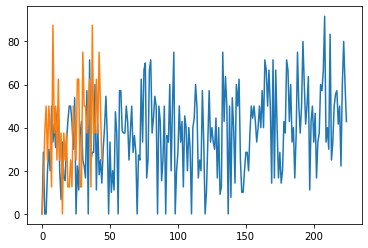

In [24]:
plt.plot(train)
plt.plot(test)

In [26]:
train_fname = '/content/train_acc_vanilla.bin'
with open(train_fname,'wb') as file:
  pickle.dump(train_acc,file)
test_fname = '/content/test_acc_vanilla.bin'
with open(test_fname,'wb') as file:
  pickle.dump(test_acc,file)

Visualization

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [6]:
with open('/content/train_acc_vanilla.bin','rb') as file:
  va_tr = pickle.load(file)
with open('/content/train_acc_vanilla.bin','rb') as file:
  va_te = pickle.load(file)
with open('/content/train_acc_0.5.bin','rb') as file:
  eps1_tr = pickle.load(file)
with open('/content/train_acc_2.bin','rb') as file:
  eps2_tr = pickle.load(file)
with open('/content/train_acc_5.bin','rb') as file:
  eps3_tr = pickle.load(file)
with open('/content/train_acc_15.bin','rb') as file:
  eps4_tr = pickle.load(file)
with open('/content/test_acc_0.5.bin','rb') as file:
  eps1_te = pickle.load(file)
with open('/content/test_acc_2.bin','rb') as file:
  eps2_te = pickle.load(file)
with open('/content/test_acc_5.bin','rb') as file:
  eps3_te = pickle.load(file)
with open('/content/test_acc_15.bin','rb') as file:
  eps4_te = pickle.load(file)

In [7]:
eps1_train=[]
eps2_train=[]
eps3_train=[]
eps4_train=[]
for i in range(0,len(eps1_tr),120):
  eps1_train.append(np.average(eps1_tr[i:i+120])*100)
for i in range(0,len(eps2_tr),120):
  eps2_train.append(np.average(eps2_tr[i:i+120])*100)
for i in range(0,len(eps3_tr),120):
  eps3_train.append(np.average(eps3_tr[i:i+120])*100)
for i in range(0,len(eps4_tr),120):
  eps4_train.append(np.average(eps4_tr[i:i+120])*100)


In [8]:
eps1_test=[]
eps2_test=[]
eps3_test=[]
eps4_test=[]
for i in range(0,len(eps1_te),120):
  eps1_test.append(np.average(eps1_te[i:i+120])*100)
for i in range(0,len(eps2_te),120):
  eps2_test.append(np.average(eps2_te[i:i+120])*100)
for i in range(0,len(eps3_te),120):
  eps3_test.append(np.average(eps3_te[i:i+120])*100)
for i in range(0,len(eps4_te),120):
  eps4_test.append(np.average(eps4_te[i:i+120])*100)


In [9]:
va_train = []
va_test = []
for i in range(0,len(va_tr),500):
  va_train.append(np.average(va_tr[i:i+500])*100)
for i in range(0,len(va_te),500):
  va_test.append(np.average(va_te[i:i+500])*100)

In [18]:
font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

In [34]:
plt.rcParams["figure.figsize"] = (10,7)

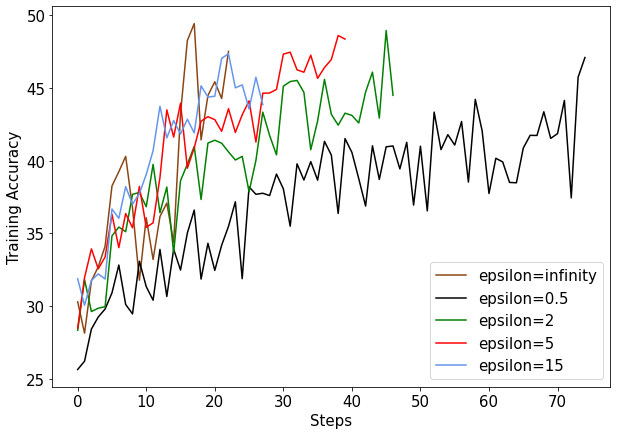

In [36]:
plt.plot(va_train,label='epsilon=infinity', color = 'saddlebrown',)
plt.plot(eps1_train,label='epsilon=0.5', color = 'black')
plt.plot(eps2_train,label='epsilon=2', color = 'green')
plt.plot(eps3_train,label='epsilon=5', color = 'red')
plt.plot(eps4_train,label='epsilon=15', color = 'cornflowerblue')
plt.xlabel('Steps')
plt.ylabel('Training Accuracy')
plt.legend()
plt.savefig('train.jpg')
plt.show()


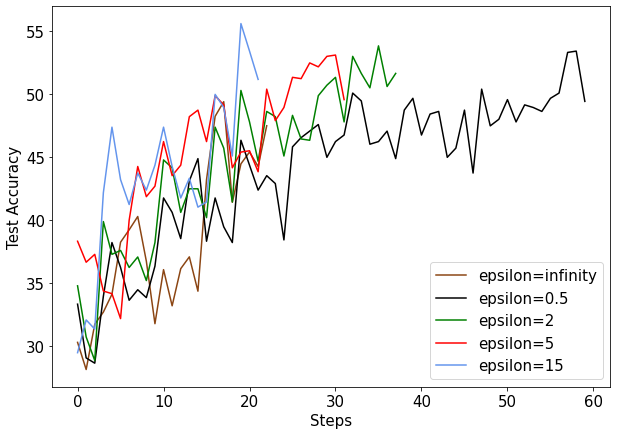

In [37]:
plt.plot(va_test,label='epsilon=infinity', color = 'saddlebrown',)
plt.plot(eps1_test,label='epsilon=0.5', color = 'black')
plt.plot(eps2_test,label='epsilon=2', color = 'green')
plt.plot(eps3_test,label='epsilon=5', color = 'red')
plt.plot(eps4_test,label='epsilon=15', color = 'cornflowerblue')
plt.xlabel('Steps')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('test.jpg')
plt.show()